# Example input parsing for Negishi dataset

### Import libraries

In [4]:
%matplotlib inline 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import importlib
importlib.reload(utils)
from sklearn import preprocessing
from tqdm import tqdm
from joblib import dump, load
from collections import Counter
from multiprocessing import Pool
from multiprocessing import freeze_support

### Load dataset

In [3]:
# Create input dataframe
n_rows = 6392
rc_df, my_path = utils.load_base_xlsx(
    xl_name='Negishi_binned_final.xlsx', 
    sheet_name='binned_final',
    usecols = tuple(range(3, 15)),
    nrows = n_rows,
    columns=(['reactant_1', 'reactant_2', 'product', 'yield'] +
             ['reagent_' + str(i) for i in range(1, 5)] +
             ['solvent_' + str(i) for i in range(1, 4)] +
             ['temp'])
)

Reading sheet binned_final


In [55]:
# Remove entries with null values in key fields
rc_df = rc_df.dropna(axis='index', subset=['reactant_1', 'reactant_2', 'product', 'yield'])

# Remove entries with failed RDKit parsing
rc_df = rc_df[rc_df['reactant_1'].apply(Chem.MolFromSmiles).notna()]
rc_df = rc_df[rc_df['reactant_2'].apply(Chem.MolFromSmiles).notna()]
rc_df = rc_df[rc_df['product'].apply(Chem.MolFromSmiles).notna()]

RDKit ERROR: [14:45:51] Explicit valence for atom # 7 N, 5, is greater than permitted
RDKit ERROR: [14:45:51] Explicit valence for atom # 4 N, 5, is greater than permitted
RDKit ERROR: [14:45:51] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:45:55] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [14:45:55] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:45:56] Explicit valence for atom # 2 B, 4, is greater than permitted
RDKit ERROR: [14:45:56] Explicit valence for atom # 2 B, 4, is greater than permitted
RDKit ERROR: [14:45:57] Explicit valence for atom # 12 B, 4, is greater than permitted
RDKit ERROR: [14:45:57] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:46:01] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:46:01] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:46:01] Explicit valence for atom # 1

In [5]:
# View dataset details
print(rc_df.describe(include = 'all'))
print('Number of NaNs:')
print(len(rc_df) - rc_df.count())

        reactant_1  reactant_2                     product        yield  \
count         6391        6391                        6391  6391.000000   
unique        2792        1743                        5293          NaN   
top     N#C[Zn]C#N  N#C[Zn]C#N  COC1=CC=C(C=C1)C1=CC=CC=C1          NaN   
freq           168         673                          21          NaN   
mean           NaN         NaN                         NaN     0.711007   
std            NaN         NaN                         NaN     0.219216   
min            NaN         NaN                         NaN     0.005200   
25%            NaN         NaN                         NaN     0.590000   
50%            NaN         NaN                         NaN     0.760000   
75%            NaN         NaN                         NaN     0.889000   
max            NaN         NaN                         NaN     1.000000   

       reagent_1 reagent_2 reagent_3 reagent_4 solvent_1 solvent_2 solvent_3  \
count       6317   

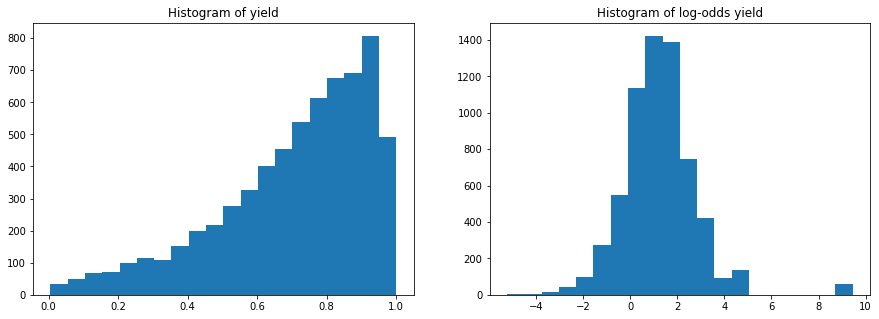

In [9]:
# Plot dataset yield distributions
y = rc_df['yield']
y = (y * (len(y) - 1) + 0.5)/len(y)
fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].hist(y, 20);
axes[0].set_title('Histogram of yield');
axes[1].hist(np.log(y/(1-y)), bins = 20);
axes[1].set_title('Histogram of log-odds yield');

Text(0.5, 1.0, 'Histograms on length of SMILES')

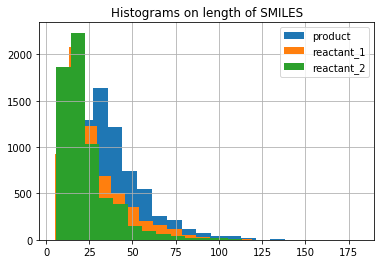

In [10]:
# Plot SMILES length distributions for each reaction component
rc_df['product'].str.len().hist(bins=20, label='product')
rc_df.reactant_1.str.len().hist(bins=20, label='reactant_1')
rc_df.reactant_2.str.len().hist(bins=20, label='reactant_2')
plt.legend();
plt.title('Histograms on length of SMILES')

### Create tokenized SMILES inputs

In [5]:
def get_char_dict(df, smiles_vec_len=100, get_counts=False):
    """
    Creates SMILES token dictionary
    
    ARGUMENTS:
        (pandas.DataFrame)df: dataframe of reaction inputs containing 
                                starting material and product SMILES
        (int)smiles_vec_len: maximum SMILES length. Tokenized SMILES will 
                                be 0-padded to this length
        (bool)get_counts: whether or not to record character frequencies
    
    RETURNS:
        (dict)char_dict: dictionary of SMILES character to token number mapping
    """
    # Filter dataset for molecules with SMILES length under max threshold 
    df = df[df["reactant_1"].str.len() < smiles_vec_len]
    df = df[df["reactant_2"].str.len() < smiles_vec_len]
    df = df[df["product"].str.len() < smiles_vec_len]
    
    # Set character counter for tokenization
    char_counts = Counter()
    for reactant in tqdm(df["reactant_1"] + df["reactant_2"] + df["product"]):
        # Show unique characters
        if type(reactant) is float:
            print(reactant)
        # Update character token set
        char_counts.update(reactant)
        
    # Create unique character dictionary
    char_dict = {char: ord(char) for char in char_counts}
    if get_counts:
        return char_dict, char_counts

    return char_dict


def rc_table_process_smiles(df, create_one_hot=True, smiles_vec_len=100):
    """
    Prepares tokenized SMILES for full dataset inputs
    
    ARGUMENTS:
        (pandas.DataFrame)df: dataframe of reaction inputs containing 
                                starting material and product SMILES
        (bool)create_one_hot: whether or not to one-hot-encode the 
                                tokenized SMILES vectors 
        (int)smiles_vec_len: maximum SMILES length. Tokenized SMILES will 
                                be 0-padded to this length
    
    RETURNS:
        (pandas.DataFrame)smiles_df: dataframe of reaction inputs containing 
                                        tokenized SMILES representations
    """
    # Create dictionary of SMILES character to token number mapping
    char_dict = get_char_dict(df)
    num_chars = len(char_dict)
    # Set maximum SMILES length for padding
    if smiles_vec_len == None:
        smiles_vec_len = max(df["reactant_1"].str.len().max(),
                             df["reactant_2"].str.len().max(),
                             df["product"].str.len().max())
    # Filter dataset for SMILES length under max threshold if supplied
    else:
        df = df[df["reactant_1"].str.len() < smiles_vec_len]
        df = df[df["reactant_2"].str.len() < smiles_vec_len]
        df = df[df["product"].str.len() < smiles_vec_len]
    # Create numpy array for full dataset to be filled by token vectors
    # Set matrix to support one-hot length if specified
    if create_one_hot:
        mat = np.zeros((len(df), num_chars * smiles_vec_len * 3))
    else:
        mat = np.zeros((len(df), smiles_vec_len * 3))
    for row, i in tqdm(enumerate(df.index)):
        # Get one hot arrays (large dimensions!)
        if create_one_hot:
            for j, letter in enumerate(df["reactant_1"][i]):
                mat[row, num_chars * j + char_dict[letter]] = 1
            for j, letter in enumerate(df["reactant_2"][i]):
                mat[row, num_chars * (smiles_vec_len + j) + char_dict[letter]] = 1
            for j, letter in enumerate(df["product"][i]):
                mat[row, num_chars * (smiles_vec_len * 2 + j) + char_dict[letter]] = 1
        # Fill in array with proper character tokens
        else: 
            for j, letter in enumerate(df["reactant_1"][i]):
                mat[row, j] = char_dict[letter]
            for j, letter in enumerate(df["reactant_2"][i]):
                mat[row, smiles_vec_len + j] = char_dict[letter]
            for j, letter in enumerate(df["product"][i]):
                mat[row, smiles_vec_len * 2 + j] = char_dict[letter]
                
    # Create dataframe from the matrix inputs
    smiles_df = pd.DataFrame(mat, index=df.index)
    return smiles_df

### Create binary output vectors

In [139]:
n_metals = 32
n_ligands = 20
n_bases = 0
n_solvents = 10
n_additives = 30
n_temps = 8
n_other = 1
total_reagents = n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps + n_other    
    
reagent_cols = [col for col in rc_df.columns if 'reagent' in col or 'solvent' in col or col == 'temp']
offsets = {
    'M': 0,
    'L': n_metals,
    'S': n_metals + n_ligands + n_bases,
    'A': n_metals + n_ligands + n_bases + n_solvents,
    'T': n_metals + n_ligands + n_bases + n_solvents + n_additives,
}
cutoffs = [
    0,
    n_metals,
    n_metals + n_ligands,
    n_metals + n_ligands + n_bases + n_solvents,
    n_metals + n_ligands + n_bases + n_solvents + n_additives,
    n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps,
    n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps + n_other,
]
group_names = [
    'metals', 'ligands', 'solvents', 'additives', 'temp', 'other'
]

def run_multiprocessing(func, i, n_processors):
    with Pool(processes=n_processors) as pool:
        return pool.map(func, i)

def calc_reagent_vec(i):
    reagent_vec = np.zeros(total_reagents)
    for reagent_col in reagent_cols:
        reagent_id = rc_df.loc[i][reagent_col]
        if not pd.isna(reagent_id):
            # anything else
            if len(reagent_id) > 3:
                ind = -1
                reagent_vec[ind] = 1
            else:
                # a category code like M1
                prefix = reagent_id[0]
                if prefix not in offsets or len(reagent_id) > 3:
                    print(prefix, reagent_id, len(prefix), len(reagent_id))
                    continue
                ind = int(reagent_id[1:])
                reagent_vec[offsets[prefix] + ind - 1] = 1
    return reagent_vec

def rc_table_process_reagents(df):
    # set up parameters required by the task
    n_processors = 6
    # pass the task function, followed by the parameters to processors
    reagent_vecs = run_multiprocessing(calc_reagent_vec, list(df.index), n_processors)
    
    columns = ['reagent_{}'.format(i) for i in range(total_reagents)]
    reagents_df = pd.DataFrame(reagent_vecs, columns=columns, index=df.index)
    return reagents_df

### Get Mordred input vectors

In [8]:
def rc_table_get_mordred(normalize=True, nrows=None, reaction_type='negishi'):
    """
    Gets Mordred descriptor vectors calculated in separate notebook to 
    create hybrid input representations
    
    ARGUMENTS:
        (bool)normalize: whether or not to normalize each column of the 
                            descriptor vectors
        (int)nrows: number of rows to feed to pd.read_csv for importing
                    Mordred vector dataset
        (str)reaction_type: name of reaction type for retrieving Mordred file
                            (assumes this file exists at the path found 
                            when loading the dataset)
    
    RETURNS:
        (pandas.DataFrame)reagents_df: dataframe of reaction outputs containing 
                                        one-hot vector representations
    """
    # Load Mordred vector dataset inputs separated by reaction components
    # Reactant 1
    rdfred_1_df = pd.read_csv(my_path+reaction_type+'_reactants_1_mordred.csv',
                              nrows=nrows, index_col='Unnamed: 0')
    rdfred_1_df.columns = 'rdfred_1_' + rdfred_1_df.columns
    # Reactant 2
    rdfred_2_df = pd.read_csv(my_path+reaction_type+'_reactants_2_mordred.csv',
                              nrows=nrows, index_col='Unnamed: 0')
    rdfred_2_df.columns = 'rdfred_2_' + rdfred_2_df.columns
    # Product
    pdfred_df = pd.read_csv(my_path+reaction_type+'_products_mordred.csv',
                            nrows=nrows, index_col='Unnamed: 0')
    pdfred_df.columns = 'product_' + pdfred_df.columns
    # Merge to single dataframe with full length vectors
    mordred_df = rdfred_1_df.merge(
        rdfred_2_df, left_index=True, right_index=True
    ).merge(pdfred_df, left_index=True, right_index=True)

    # Normalize columns if specified
    if normalize:
        mordred_df = (mordred_df - mordred_df.mean()) / mordred_df.std()
    return mordred_df

## Full processing

In [79]:
# Control how much to read (using full dataset here)
n_samples = n_rows

In [80]:
# View raw dataset sample
rc_df.loc[:n_samples].head()

,reactant_1,reactant_2,product,yield,reagent_1,reagent_2,reagent_3,reagent_4,solvent_1,solvent_2,solvent_3,temp
0,BrC1=CC=CC(Br)=N1,Br[Zn]C1=NC=CC=C1,BrC1=CC=CC(=N1)C1=NC=CC=C1,0.540,M1,NaN,NaN,NaN,S1,NaN,NaN,T2
1,BrC1=CC=CC(=N1)C1=NC(Br)=CC=C1,Br[Zn]C1=NC=CC=C1,BrC1=NC(=CC=C1)C1=NC(=CC=C1)C1=NC=CC=C1,0.524,M1,NaN,NaN,NaN,S1,NaN,NaN,T2
2,ClC1=CC=C(C=C1)C#N,Cl[Zn]C1=CC=CC=C1,N#CC1=CC=C(C=C1)C1=CC=CC=C1,0.650,M22,NaN,NaN,NaN,S1,NaN,NaN,T1
3,COCOC1=CC(OCOC)=C(Br)C(C)=C1,Br[Zn]C1CCCCC1,COCOC1=CC(OCOC)=C(C2CCCCC2)C(C)=C1,0.850,L9,M4,NaN,NaN,S1,NaN,NaN,T2
4,Cl[Zn]C#C,I\C=C\CCOC1CCCCO1,C#C\C=C\CCOC1CCCCO1,0.910,tetrabutyl ammonium fluoride,acetic acid,NaN,NaN,S1,NaN,NaN,T2


In [35]:
# Tokenize SMILES string inputs
smiles_df = rc_table_process_smiles(rc_df.loc[:n_samples], create_one_hot=False)

100%|██████████| 6298/6298 [00:00<00:00, 122724.00it/s]
6298it [00:00, 11092.62it/s]


In [36]:
# View tokenized SMILES vectors
smiles_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,79.0,67.0,79.0,67.0,49.0,61.0,67.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,108.0,91.0,90.0,110.0,93.0,67.0,35.0,67.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
print(smiles_df.shape)
print(smiles_df.max().max())

(6298, 300)
114.0


In [ ]:
# Create output dataframe with binary reagent vectors
reagents_df = rc_table_process_reagents(rc_df.loc[:n_samples])

In [134]:
# View output sample
print(reagents_df.shape)
reagents_df.head()

(6391, 101)


,reagent_0,reagent_1,reagent_2,reagent_3,reagent_4,reagent_5,reagent_6,reagent_7,reagent_8,reagent_9,...,reagent_91,reagent_92,reagent_93,reagent_94,reagent_95,reagent_96,reagent_97,reagent_98,reagent_99,reagent_100
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [135]:
# Show frequency of each reagent
reagents_df.values.astype(int).sum(axis=0)

array([1860,  551,  411,  355,  339,  329,  273,  247,  168,  101,   99,
         87,   63,   56,   56,   46,   45,   37,   96,   42,   39,   37,
         35,   34,   30,   30,   29,   29,   27,   27,   24,   23,  228,
        189,  187,  154,  124,   95,   52,   61,   37,   37,   35,   33,
         31,   24,   22,   21,   20,   20,   19,   18, 4525, 1003,  674,
        541,  335,  247,  219,  203,  122,   67,  242,  205,  153,   62,
         56,   14,   51,   45,   42,   42,   42,   36,   36,   32,   29,
         30,   28,   23,   22,   20,   20,   20,   19,   18,   16,   15,
         12,   11,   11,   11,  103, 2195,  640,  960,  654,  668,  695,
        476, 1083])

In [148]:
# View sample output vector
reagents_df.loc[0].values

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [159]:
# Insert 'NULL' labels in each category when no reagent is present
reagents_df_nulls = utils.add_null_labels(reagents_df, cutoffs=cutoffs, group_names=group_names)

cutoffs [0, 32, 52, 62, 92, 100, 101]


In [160]:
# View final dataframe sample
print(reagents_df_nulls.shape)
reagents_df_nulls.head()

(6397, 107)


,reagent_0,reagent_1,reagent_2,reagent_3,reagent_4,reagent_5,reagent_6,reagent_7,reagent_8,reagent_9,...,reagent_97,reagent_98,reagent_99,reagent_100,null_metals,null_ligands,null_solvents,null_additives,null_temp,null_other
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,1
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,1,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1,1,0,1,0,0


In [161]:
# Show frequency of each reagent
reagents_df_nulls.values.astype(int).sum(axis=0)

array([1860,  551,  411,  355,  339,  329,  273,  247,  168,  101,   99,
         87,   63,   56,   56,   46,   45,   37,   96,   42,   39,   37,
         35,   34,   30,   30,   29,   29,   27,   27,   24,   23,  228,
        189,  187,  154,  124,   95,   52,   61,   37,   37,   35,   33,
         31,   24,   22,   21,   20,   20,   19,   18, 4525, 1003,  674,
        541,  335,  247,  219,  203,  122,   67,  242,  205,  153,   62,
         56,   14,   51,   45,   42,   42,   42,   36,   36,   32,   29,
         30,   28,   23,   22,   20,   20,   20,   19,   18,   16,   15,
         12,   11,   11,   11,  103, 2195,  640,  960,  654,  668,  695,
        476, 1083,  801, 4995,  130, 5318,    6, 5314])

In [162]:
# View sample output vector
reagents_df_nulls.loc[0].values

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1.])

In [163]:
# Load Mordred dataframe
filtered_mordred_df = rc_table_get_mordred(normalize=True, nrows=n_samples, reaction_type='negishi')

In [164]:
# View details of Mordred vectors
print(filtered_mordred_df.shape)
print(filtered_mordred_df.head())

(6242, 2004)
   rdfred_1_Diameter  rdfred_1_ATSC1m  rdfred_1_piPC3  rdfred_1_n5aHRing  \
0                  4    -1.901154e+01        3.409496                  0   
1                  7    -1.121152e+00        4.226834                  0   
2                  6    -4.796163e-14        3.669951                  0   
3                 10     4.178395e+01        3.956040                  0   
4                  3     3.753147e+02        1.386294                  0   

   rdfred_1_n4AHRing  rdfred_1_EState_VSA3  rdfred_1_ATS0i  rdfred_1_SaaSe  \
0                  0              0.000000     1679.096540             0.0   
1                  0              0.000000     3079.061340             0.0   
2                  0             10.586085     2006.630591             0.0   
3                  0             11.499024     5049.873711             0.0   
4                  0              0.000000      694.916767             0.0   

   rdfred_1_CIC3  rdfred_1_ATSC1p  ...  product_NsssN  produc

## Create final dataset with hybrid reaction encoding

In [166]:
# Merge SMILES and Mordred input vectors to create hybrid representation
X_full = smiles_df.merge(
    filtered_mordred_df, left_index=True, right_index=True
)

# Get output vectors corresponding to inputs
y_full = reagents_df_nulls[reagents_df_nulls.index.isin(X_full.index)]

### Save datasets to be loaded for modeling

In [171]:
# Create input and output csv files for processed dataset
X_full.to_csv(my_path+"X_full_negishi.csv")
y_full.to_csv(my_path+"y_full_negishi.csv")